# Chapter 13: Combining Methods: Ensembles and Uplift Modeling


> (c) 2019-2020 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.
>
> Date: 2020-03-08
>
> Python Version: 3.8.2
> Jupyter Notebook Version: 5.6.1
>
> Packages:
>   - dmba: 0.0.12
>   - matplotlib: 3.2.0
>   - pandas: 1.0.1
>   - scikit-learn: 0.22.2
>
> The assistance from Mr. Kuber Deokar and Ms. Anuja Kulkarni in preparing these solutions is gratefully acknowledged.


In [1]:
# Import required packages for this chapter
from pathlib import Path

import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

import matplotlib.pylab as plt

from dmba import classificationSummary
from dmba import liftChart

%matplotlib inline

In [2]:
# Working directory:
#
# We assume that data are kept in the same directory as the notebook. If you keep your 
# data in a different folder, replace the argument of the `Path`
DATA = Path('.').resolve().parent / 'data'
FIGURES = Path('.').resolve().parent / 'figures' / 'chapter_13'
FIGURES.mkdir(exist_ok=True, parents=True)
# and then load data using 
#
# pd.read_csv(DATA / ‘filename.csv’)

# Problem 13.1: Acceptance of Consumer Loan
Universal Bank has begun a program to encourage its existing customers to borrow via a consumer loan program.  The bank has promoted the loan to 5000 customers, of whom 480 accepted the offer. The data are available in file __UniversalBank.csv__. The bank now wants to develop a model to predict which customers have the greatest probability of accepting the loan, to reduce promotion costs and send the offer only to a subset of its customers. 

We will develop several models, then combine them in an ensemble.  The models we will use are 
1. logistic regression, 
2. $k$-nearest neighbors with $k=3$, and 
3. classification trees

## Data preprocessing
Preprocess the data as follows:

- Bin the following variables so they can be used in Naive Bayes:  Age (5 bins), Experience (10 bins), Income (5 bins), CC Average (6 bins), and Mortgage (10 bins).
- Education and Family can be used as is, without binning. 
- Zip code can be ignored.
- Use one-hot-encoding to convert the categorical data into indicator variables
- Partition the data: 60% training, 40% validation.


In [3]:
bank_df = pd.read_csv(DATA / 'UniversalBank.csv')
bank_df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [4]:
# Drop ID and zip code columns
bank_df.drop(columns=['ID', 'ZIP Code'], inplace=True)

# The remaining columns (Age, Experience, Income, Mortgage and CCAvg) will be binned
bank_df['Age'] = pd.cut(bank_df['Age'], 5, labels=range(1, 6)).astype('category')
bank_df['Experience'] = pd.cut(bank_df['Experience'], 10, labels=range(1, 11)).astype('category')
bank_df['Income'] = pd.cut(bank_df['Income'], 5, labels=range(1, 6)).astype('category')
bank_df['CCAvg'] = pd.cut(bank_df['CCAvg'], 6, labels=range(1, 7)).astype('category')
bank_df['Mortgage'] = pd.cut(bank_df['Mortgage'], 10, labels=range(1, 11)).astype('category')

# Use one-hot-encoding for the 
X = bank_df.drop(columns=['Personal Loan'])
X = pd.get_dummies(X)

y = bank_df['Personal Loan']

In [5]:
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
print('Training set:', train_X.shape, 'Validation set:', valid_X.shape)

Training set: (3000, 42) Validation set: (2000, 42)


## Solution 13.1.a
Fit models to the data for 
1. logistic regression, 
2. $k$-nearest neighbors with $k=3$, 
3. classification trees, and 
4. Naive Bayes. 

Use Personal Loan as the outcome variable.  Report the validation confusion matrix for each of the models.

In [6]:
# Logistic regression
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)
classificationSummary(valid_y, logit_reg.predict(valid_X))

# k-nearest neighbors
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_X, train_y)
classificationSummary(valid_y, knn.predict(valid_X))

Confusion Matrix (Accuracy 0.9490)

       Prediction
Actual    0    1
     0 1773   34
     1   68  125
Confusion Matrix (Accuracy 0.9360)

       Prediction
Actual    0    1
     0 1798    9
     1  119   74


In [7]:
# classification tree
# user grid search to find optimized tree
param_grid = {
    'max_depth': [5, 10, 15, 20, 25], 
    'min_impurity_decrease': [0, 0.001, 0.005, 0.01], 
    'min_samples_split': [10, 20, 30, 40, 50], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Initial parameters: ', gridSearch.best_params_)

param_grid = {
    'max_depth': [5, 6, 7, 8, 9, 10, 11, 12], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.0015], 
    'min_samples_split': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved parameters: ', gridSearch.best_params_)

classTree = gridSearch.best_estimator_

classificationSummary(valid_y, classTree.predict(valid_X))

Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0.001, 'min_samples_split': 10}
Improved parameters:  {'max_depth': 7, 'min_impurity_decrease': 0, 'min_samples_split': 15}
Confusion Matrix (Accuracy 0.9670)

       Prediction
Actual    0    1
     0 1789   18
     1   48  145


In [8]:
# Naive-Bayes
nb = MultinomialNB(alpha=0.01)
nb.fit(train_X, train_y)
classificationSummary(valid_y, nb.predict(valid_X))

Confusion Matrix (Accuracy 0.8860)

       Prediction
Actual    0    1
     0 1657  150
     1   78  115


## Solution 13.1.b
Create a data frame with the actual outcome, predicted outcome, and each of the models. 
Report the first 10 rows of this data frame.

In [9]:
result = pd.DataFrame({
    'actual': valid_y,
    'Logistic regression': logit_reg.predict(valid_X),
    'k-nearest neighbor': knn.predict(valid_X),
    'classification tree': classTree.predict(valid_X),
    'naive-bayes': nb.predict(valid_X),
})
result.head(10)

,actual,Logistic regression,k-nearest neighbor,classification tree,naive-bayes
2764,0,0,0,0,0
4767,0,0,0,0,0
3814,0,0,0,0,0
3499,0,0,0,0,0
2735,0,0,0,0,0
3922,0,0,0,0,0
2701,0,0,0,0,0
1179,0,0,0,0,0
932,0,1,0,1,1
792,0,1,0,1,1


## Solution 13.1.c
Add two columns to this data frame for (1) a majority vote of predicted outcomes, and (2) the average of the predicted probabilities. Using the classifications generated by these two methods derive a confusion matrix for each method and report the overall accuracy.

In [10]:
# (1) majority vote
predColumns = ['Logistic regression', 'k-nearest neighbor', 'classification tree', 'naive-bayes']
result['majority'] = [1 if p > 0.5 else 0 for p in result[predColumns].mean(axis=1)]

# (2) average probability
# first create a data frame with the predicted probabilities for Personal Loan of 1
probabilities = pd.DataFrame({
    'actual': valid_y,
    'Logistic regression': logit_reg.predict_proba(valid_X)[:, 1],
    'k-nearest neighbor': knn.predict_proba(valid_X)[:, 1],
    'classification tree': classTree.predict_proba(valid_X)[:, 1],
    'naive-bayes': nb.predict_proba(valid_X)[:, 1],
})
result['average'] = probabilities[predColumns].mean(axis=1)
result['average_pred'] = [1 if p > 0.5 else 0 for p in result['average']]
result.head(10)

,actual,Logistic regression,k-nearest neighbor,classification tree,naive-bayes,majority,average,average_pred
2764,0,0,0,0,0,0,1.572781e-03,0
4767,0,0,0,0,0,0,2.846366e-07,0
3814,0,0,0,0,0,0,6.143648e-07,0
3499,0,0,0,0,0,0,3.452705e-02,0
2735,0,0,0,0,0,0,3.897706e-03,0
3922,0,0,0,0,0,0,1.440022e-06,0
2701,0,0,0,0,0,0,8.749563e-04,0
1179,0,0,0,0,0,0,1.418331e-01,0
932,0,1,0,1,1,1,5.011567e-01,1
792,0,1,0,1,1,1,6.453092e-01,1


In [11]:
print('Majority vote')
classificationSummary(result['actual'], result['majority'])

print('Average probability')
classificationSummary(result['actual'], result['average_pred'])

Majority vote
Confusion Matrix (Accuracy 0.9495)

       Prediction
Actual    0    1
     0 1797   10
     1   91  102
Average probability
Confusion Matrix (Accuracy 0.9595)

       Prediction
Actual    0    1
     0 1796   11
     1   70  123


## Solution 13.1.d
Compare the error rates for the four individual methods and the two ensemble methods.

In [12]:
models = ['Logistic regression', 'k-nearest neighbor', 'classification tree', 'naive-bayes', 
          'majority', 'average_pred']
errorRates = []
for model in models:
    errorRates.append({'model': model, 'error rate': accuracy_score(result['actual'], result[model])})
pd.DataFrame(errorRates)

,model,error rate
0,Logistic regression,0.9490
1,k-nearest neighbor,0.9360
2,classification tree,0.9670
3,naive-bayes,0.8860
4,majority,0.9495
5,average_pred,0.9595


The accuracy values show that the decision tree model outperforms the other three methods. The two ensemble models have slightly lower performance compared to the classification tree.

# Problem 13.2: eBay Auctions - Boosting and Bagging
Using the eBay auction data (file _eBayAuctions.csv_) with variable Competitive as the outcome variable, partition the data into training (60%) and validation (40%).

In [13]:
ebay_df = pd.read_csv(DATA / 'eBayAuctions.csv')
ebay_df.head()

,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


In [14]:
# convert categorical variables into indicator and drop the first column of each of them
ebay_df = pd.get_dummies(ebay_df, prefix_sep='_', drop_first=True)

y = ebay_df['Competitive?']
X = ebay_df.drop(columns=['Competitive?'])

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)


## Solution 13.2.a
Run a classification tree, using the default settings of `DecisionTreeClassifier`.
Looking at the validation set, what is the overall accuracy? What is the lift on the first decile?

In [15]:
classTree = DecisionTreeClassifier(random_state=1)
classTree.fit(train_X, train_y)
classificationSummary(valid_y, classTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8758)

       Prediction
Actual   0   1
     0 315  38
     1  60 376


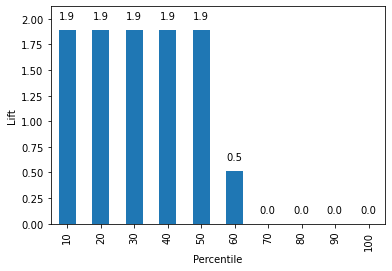

In [16]:
# Create the information for the lift chart
proba = classTree.predict_proba(valid_X)
result = pd.DataFrame({'actual': valid_y, 
                       'p(0)': [p[0] for p in proba],
                       'p(1)': [p[1] for p in proba],
                       'predicted': classTree.predict(valid_X) })

df = result.sort_values(by=['p(1)'], ascending=False)
liftChart(df['p(1)'], title=False)
plt.show()

## Solution 13.2.b
Run a boosted tree with the same predictors (use `AdaBoostClassifier` with `DecisionTreeClassifier` 
as the base estimator).
For the validation set, what is the overall accuracy? What is the lift on the first decile?

In [17]:
boost = AdaBoostClassifier(n_estimators=100, base_estimator=classTree, random_state=1)
boost.fit(train_X, train_y)

classificationSummary(valid_y, boost.predict(valid_X))

Confusion Matrix (Accuracy 0.8619)

       Prediction
Actual   0   1
     0 312  41
     1  68 368


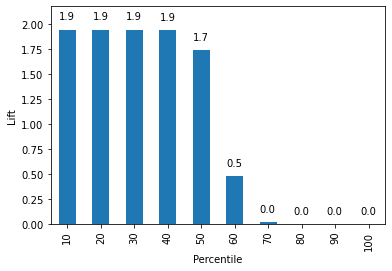

In [18]:
# Create the information for the lift chart
proba = boost.predict_proba(valid_X)
result = pd.DataFrame({'actual': valid_y, 
                       'p(0)': [p[0] for p in proba],
                       'p(1)': [p[1] for p in proba],
                       'predicted': boost.predict(valid_X) })

df = result.sort_values(by=['p(1)'], ascending=False)
liftChart(df['p(1)'], title=False)
plt.show()

## Solution 13.2.c
Run a bagged tree with the same predictors (use `BaggingClassifier`).
For the validation set, what is the overall accuracy? What is the lift on the first decile?

In [19]:
bagging = BaggingClassifier(classTree, max_samples=0.5, max_features=0.5, random_state=1)
bagging.fit(train_X, train_y)

classificationSummary(valid_y, bagging.predict(valid_X))

Confusion Matrix (Accuracy 0.8074)

       Prediction
Actual   0   1
     0 278  75
     1  77 359


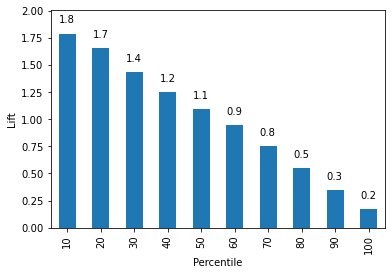

In [20]:
# Create the information for the lift chart
proba = bagging.predict_proba(valid_X)
result = pd.DataFrame({'actual': valid_y, 
                       'p(0)': [p[0] for p in proba],
                       'p(1)': [p[1] for p in proba],
                       'predicted': bagging.predict(valid_X) })

df = result.sort_values(by=['p(1)'], ascending=False)
liftChart(df['p(1)'], title=False)
plt.show()

## Solution 13.2.d
Run a random forest (use `RandomForestClassifier`). Compare the bagged tree to the random forest in terms of validation accuracy and lift on first decile. How are the two methods conceptually different?

In [21]:
rfModel = RandomForestClassifier(random_state=1, n_estimators=100)
rfModel.fit(train_X, train_y)

classificationSummary(valid_y, rfModel.predict(valid_X))

Confusion Matrix (Accuracy 0.8644)

       Prediction
Actual   0   1
     0 320  33
     1  74 362


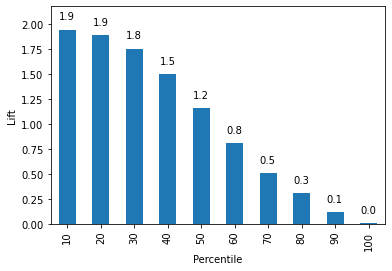

In [22]:
# Create the information for the lift chart
proba = rfModel.predict_proba(valid_X)
result = pd.DataFrame({'actual': valid_y, 
                       'p(0)': [p[0] for p in proba],
                       'p(1)': [p[1] for p in proba],
                       'predicted': rfModel.predict(valid_X) })

df = result.sort_values(by=['p(1)'], ascending=False)
liftChart(df['p(1)'], title=False)
plt.show()

# Problem 13.3 - Predicting Delayed Flights (Boosting)
The file _FlightDelays.csv_ contains information on all commercial flights departing the Washington, DC area and arriving at New York during January 2004. For each flight there is information on the departure and arrival airports, the distance of the route, the scheduled time and date of the flight, and so on. The variable that we are trying to predict is whether or not a flight is delayed. A delay is defined as an arrival that is at least 15 minutes later than scheduled.

## Data Preprocessing
Transform variable day of week info a categorical variable. 
Bin the scheduled departure time into eight bins (in Python use function `pd.cut()` from the _pandas_ package). Partition the data into training (60\%) and validation (40\%).

Run a boosted classification tree for delay. With the exception of setting \texttt{n\_estimators=500} and \texttt{random\_state=1}, use default setting for the DecisionTreeClassifier and the AdaBoostClassifier. 

\subprob Compared with the single tree, how does the boosted tree behave in terms of overall accuracy?
\subprob Compared with the single tree, how does the boosted tree behave in terms of accuracy in identifying delayed flights?
\subprob Explain why this model might have the best performance over the other models you fit.


In [23]:
data = pd.read_csv(DATA / 'FlightDelays.csv')
data = data.drop(columns=['FL_DATE', 'FL_NUM', 'TAIL_NUM', 'DEP_TIME', 'DAY_OF_MONTH'])

# transform variables and create bins
data.DAY_WEEK = data.DAY_WEEK.astype('category')
data.CRS_DEP_TIME = pd.cut(data.CRS_DEP_TIME, bins=8)
data.DEST = data.DEST.astype('category')
data.ORIGIN = data.ORIGIN.astype('category')

data = pd.get_dummies(data, drop_first=True, columns=['DAY_WEEK', 'CRS_DEP_TIME', 'DEST', 'ORIGIN', 'CARRIER'])
data.head()

,DISTANCE,Weather,Flight Status,DAY_WEEK_2,DAY_WEEK_3,DAY_WEEK_4,DAY_WEEK_5,DAY_WEEK_6,DAY_WEEK_7,"CRS_DEP_TIME_(791.25, 982.5]",...,DEST_LGA,ORIGIN_DCA,ORIGIN_IAD,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,CARRIER_RU,CARRIER_UA,CARRIER_US
0,184,0,ontime,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,213,0,ontime,0,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
2,229,0,ontime,0,0,1,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0
3,229,0,ontime,0,0,1,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0
4,229,0,ontime,0,0,1,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0


Partition the data into training (60\%) and validation (40\%).

In [24]:
y = data['Flight Status']
X = data.drop(columns=['Flight Status'])

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

Run a boosted classification tree for delay. With the exception of setting `n_estimators=500` and `random_state=1`, use default setting for the DecisionTreeClassifier and the AdaBoostClassifier. 

In [25]:
defaultOptions = {'random_state': 1}

defaultTree = DecisionTreeClassifier(**defaultOptions)
defaultTree.fit(train_X, train_y)
classificationSummary(valid_y, defaultTree.predict(valid_X), class_names=['delayed', 'ontime'])

Confusion Matrix (Accuracy 0.7310)

        Prediction
 Actual delayed  ontime
delayed      62     105
 ontime     132     582


In [26]:
boost = AdaBoostClassifier(DecisionTreeClassifier(**defaultOptions), random_state=1, n_estimators=500)

boost.fit(train_X, train_y)
classificationSummary(valid_y, boost.predict(valid_X), class_names=['delayed', 'ontime'])

Confusion Matrix (Accuracy 0.7401)

        Prediction
 Actual delayed  ontime
delayed      37     130
 ontime      99     615


## Solution 13.3.a
Compared with the single tree, how does the boosted tree behave in terms of overall accuracy?

The accuracy of the single tree is 0.73 and it is slightly higher (0.74) for the boosted tree.

## Solution 13.3.b
Compared with the single tree, how does the boosted tree behave in terms of accuracy in identifying delayed flights?

In [27]:
print('single tree: ', 62 / (62 + 105))
print('boosted tree: ', 37 / (37 + 130))

single tree:  0.3712574850299401
boosted tree:  0.2215568862275449


The single tree predicts 37% of the delayed flights correct. The boosted tree only 22%.

## Solution 13.3.c
Explain why this model might have the best performance over the other models you fit.

Boosting is an iterative procedure that develops successive trees with 
different weights applied to the records in each iteration.  It often yields
superior performance over single trees or bagged trees by concentrating 
(via the weights) on the records which were misclassified in earlier 
iterations. 

In our case, the overall accuracy of the single tree is practically identical to the boosted tree, however the accuracy in identifying delayed flights is higher.

## Additional material 13.3
In the above solution, we didn't control the complexity of the model. We can use the arguments `max_depth` and `min_samples_split` to limit the size of the trees. 

In [28]:
defaultOptions = {'random_state': 1, 'max_depth': 6, 'min_samples_split': 3, }

defaultTree = DecisionTreeClassifier(**defaultOptions)
defaultTree.fit(train_X, train_y)
classificationSummary(valid_y, defaultTree.predict(valid_X), class_names=['delayed', 'ontime'])

boost = AdaBoostClassifier(DecisionTreeClassifier(**defaultOptions), random_state=1, n_estimators=500)
boost.fit(train_X, train_y)
classificationSummary(valid_y, boost.predict(valid_X), class_names=['delayed', 'ontime'])

Confusion Matrix (Accuracy 0.8229)

        Prediction
 Actual delayed  ontime
delayed      33     134
 ontime      22     692
Confusion Matrix (Accuracy 0.7514)

        Prediction
 Actual delayed  ontime
delayed      39     128
 ontime      91     623


In [29]:
print('single tree: ', 33 / (33 + 134))
print('boosted tree: ', 39 / (39 + 128))

single tree:  0.19760479041916168
boosted tree:  0.23353293413173654


The overall accuracy of the single tree is now 0.83 while it is practically unchanged for the boosted trees (0.75). The accuracy for predicting delayed flights on the other hand drops significantly for the single tree (20%), while it improves slightly for the boosted tree (23%).

# Problem 13.4 - Hair Care Product - Uplift Modeling
This problem uses the data set in _Hair-Care-Product.csv_, courtesy of SAS. In this hypothetical case, a promotion for a hair care product was sent to some members of a buyers club.  Purchases were then recorded for both the members who got the promotion and those who did not.

In [30]:
data = pd.read_csv(DATA / 'Hair-Care-Product.csv')
data.columns = [d.replace('.', '_').replace(' ', '_').replace('__', '_') for d in data.columns]
data.head()

,Purchase,Age,Hair_Color,U_S_Region,Validation,Promotion_ord,Gender_ord,Residence_ord
0,0,25,Black,Southwest,1,1,0,1
1,0,30,Black,Northwest,1,0,0,1
2,0,45,Red,Northeast,1,0,0,0
3,0,35,Blond,Southwest,0,0,0,1
4,0,33,Brown,Southwest,0,1,0,1


## Solution 13.4.a 
What is the purchase propensity 
### 13.4.a.i
among those who received the promotion? 
> The purchase propensity among those who received the promotion
= (Number of purchases made) / (Total Number of Records)

The `Promotion_ord` column has a 1 for members that received a promotion. The `Purchase` column has a 1 for members that purchased a product after the promotion. By multiplying the two columns we therefore get a 1 for all members that received a promotion and made a purchase and a 0 otherwise. 

In [31]:
# Number of purchases made for members that got a promotion
print("Number of purchases made", sum(data['Purchase'] * data['Promotion_ord']))

# Number of members that got a promotion
print("Total Number of Records", sum(data['Promotion_ord']))

# Purchase propensity
print("80 / 4976 = ", sum(data['Purchase'] * data['Promotion_ord']) / sum(data['Promotion_ord']))

Number of purchases made 80
Total Number of Records 4976
80 / 4976 =  0.01607717041800643


### 13.4.a.ii
among those who did not receive the promotion?

In [32]:
# Number of purchases made for members that got a promotion
print("Number of purchases made", sum(data['Purchase'] * (1 - data['Promotion_ord'])))

# Number of members that got a promotion
print("Total Number of Records", sum(1 - data['Promotion_ord']))

# Purchase propensity
print("32 / 5024 = ", sum(data['Purchase'] * (1 - data['Promotion_ord'])) / sum(1 - data['Promotion_ord']))

Number of purchases made 32
Total Number of Records 5024
32 / 5024 =  0.006369426751592357


## Solution 13.4.b
Partition the data into training (60\%) and validation (40\%)

In [33]:
data.Hair_Color = data.Hair_Color.astype('category')
data.U_S_Region = data.U_S_Region.astype('category')
data = pd.get_dummies(data, drop_first=True)
data.head()
# KNeighborsClassifier(n_neighbors=row.k).fit(trainNorm[['zIncome', 'zLot_Size']], trainNorm['Ownership'])

,Purchase,Age,Validation,Promotion_ord,Gender_ord,Residence_ord,Hair_Color_Blond,Hair_Color_Brown,Hair_Color_Red,U_S_Region_Northwest,U_S_Region_Southeast,U_S_Region_Southwest
0,0,25,1,1,0,1,0,0,0,0,0,1
1,0,30,1,0,0,1,0,0,0,1,0,0
2,0,45,1,0,0,0,0,0,1,0,0,0
3,0,35,0,0,0,1,1,0,0,0,0,1
4,0,33,0,1,0,1,0,1,0,0,0,1


In [34]:
y = data['Purchase']
X = data.drop(columns=['Purchase'])

# Standardize the dataset
scaler = preprocessing.StandardScaler()
X_norm = scaler.fit_transform(X * 1.0)

data_norm = pd.concat([pd.DataFrame(X_norm, columns=data.columns[1:]),
                       data['Purchase']], axis=1)
train, valid = train_test_split(data_norm, test_size=0.4, random_state=1)

### Solution 13.4.b.i
Uplift using a Random Forest.

In [35]:
rfModel = RandomForestClassifier(n_estimators=100)
rfModel.fit(train.drop(columns=['Purchase']), train.Purchase)

pred = rfModel.predict(valid.drop(columns=['Purchase']))
classificationSummary(valid.Purchase, pred)

Confusion Matrix (Accuracy 0.9840)

       Prediction
Actual    0    1
     0 3936   12
     1   52    0


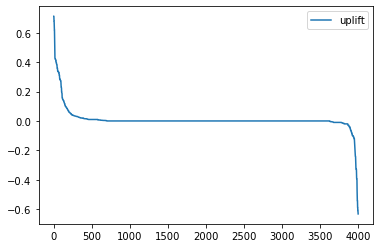

In [36]:
uplift_df = valid.drop(columns=['Purchase']).copy()  # Need to create a copy to allow modifying data

uplift_df.Promotion_ord = 1
predTreatment = rfModel.predict_proba(uplift_df)
uplift_df.Promotion_ord = 0
predControl = rfModel.predict_proba(uplift_df)

upliftResult_rf = pd.DataFrame({
    'probMessage': predTreatment[:,1],
    'probNoMessage': predControl[:,1],
    'uplift': predTreatment[:,1] - predControl[:,1],
    }, index=uplift_df.index)
upliftResult_rf = upliftResult_rf.sort_values(by=['uplift'], ascending=False)
upliftResult_rf.reset_index().plot(x=None, y='uplift')
plt.show()

### Solution 13.4.b.ii
Uplift using $k$-NN.

In [37]:
knnModel = KNeighborsClassifier(n_neighbors=11)
knnModel.fit(train.drop(columns=['Purchase']), train.Purchase)

pred = knnModel.predict(valid.drop(columns=['Purchase']))
classificationSummary(valid.Purchase, pred)

Confusion Matrix (Accuracy 0.9870)

       Prediction
Actual    0    1
     0 3948    0
     1   52    0


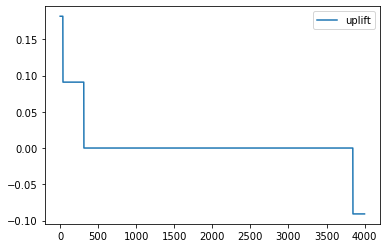

In [38]:
uplift_df = valid.drop(columns=['Purchase']).copy()  # Need to create a copy to allow modifying data

uplift_df.Promotion_ord = 1
predTreatment = knnModel.predict_proba(uplift_df)
uplift_df.Promotion_ord = 0
predControl = knnModel.predict_proba(uplift_df)

upliftResult_knn = pd.DataFrame({
    'probMessage': predTreatment[:,1],
    'probNoMessage': predControl[:,1],
    'uplift': predTreatment[:,1] - predControl[:,1],
    }, index=uplift_df.index)
upliftResult_knn = upliftResult_knn.sort_values(by=['uplift'], ascending=False)
upliftResult_knn.reset_index().plot(x=None, y='uplift')
plt.show()

## Solution 13.4.c
Report the two models' recommendations for the first three members.

In [39]:
upliftResult_rf.head(3)

,probMessage,probNoMessage,uplift
6751,0.723333,0.01,0.713333
201,0.723333,0.01,0.713333
3380,0.730000,0.04,0.690000


In [40]:
upliftResult_knn.head(3)

,probMessage,probNoMessage,uplift
7317,0.181818,0.0,0.181818
7451,0.181818,0.0,0.181818
9520,0.181818,0.0,0.181818
